In [1]:
import MeCab

In [3]:
text = "今何時ですか？"

In [4]:
wakati = MeCab.Tagger("-Owakati")
words = wakati.parse(text).split()

In [5]:
print(words)

['今', '何', '時', 'です', 'か', '？']


In [6]:
from gensim.models.keyedvectors import KeyedVectors
w2v = KeyedVectors.load_word2vec_format("language_process/entity_vector/entity_vector.model.bin", binary = True)

C:\Users\mkopm\anaconda3\envs\mytorch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
xn = torch.tensor([w2v[w] for w in words])
xn.shape

torch.Size([6, 200])

In [ ]:
#LSTM品詞分類

In [5]:
import pickle
dicpkl = "./language_process/LSTMpkls/dic.pkl"
xtpkl = "./language_process/LSTMpkls/xtrain.pkl"
ytpkl = "./language_process/LSTMpkls/ytrain.pkl"
labpkl = "./language_process/LSTMpkls/label.pkl"


with open(dicpkl,'br') as f:
  dic = pickle.load(f)

with open(xtpkl,'br') as f:
  xtrain = pickle.load(f)

with open(ytpkl,'br') as f:
  ytrain = pickle.load(f)

with open(labpkl,'br') as f:
  label = pickle.load(f)

In [12]:
xtrain[6], ytrain[6]

([74, 75, 2, 60, 76, 62, 5, 6], [9, 0, 1, 8, 5, 7, 3, 4])

In [13]:
label

{'名詞': 0,
 '助詞': 1,
 '形容詞': 2,
 '助動詞': 3,
 '補助記号': 4,
 '動詞': 5,
 '代名詞': 6,
 '接尾辞': 7,
 '副詞': 8,
 '形状詞': 9,
 '記号': 10,
 '連体詞': 11,
 '接頭辞': 12,
 '接続詞': 13,
 '感動詞': 14,
 '空白': 15}

In [14]:
dic

{'万能': 1,
 'で': 2,
 'は': 3,
 'ない': 4,
 'です': 5,
 '。': 6,
 'も': 7,
 '、': 8,
 '他': 9,
 'の': 10,
 '書籍': 11,
 '勉強': 12,
 'し': 13,
 'て': 14,
 'い': 15,
 '行き詰っ': 16,
 'た': 17,
 'とき': 18,
 'に': 19,
 'すごく': 20,
 'コンパクト': 21,
 'まとまっ': 22,
 'いる': 23,
 '便利': 24,
 'これ': 25,
 '一': 26,
 '冊': 27,
 'なん': 28,
 'と': 29,
 'か': 30,
 'しよう': 31,
 'する': 32,
 '危険': 33,
 'が': 34,
 '独学': 35,
 '暗中': 36,
 '模索': 37,
 'な': 38,
 '人': 39,
 'けっこう': 40,
 '役': 41,
 '立つ': 42,
 '思い': 43,
 'ます': 44,
 'SketchUp': 45,
 '本': 46,
 'なかなか': 47,
 '出': 48,
 '探し': 49,
 'まし': 50,
 '基本': 51,
 '操作': 52,
 'ほとんど': 53,
 '網羅': 54,
 '初心': 55,
 '者': 56,
 '特に': 57,
 '建築': 58,
 '系': 59,
 'とても': 60,
 '使い': 61,
 'やすい': 62,
 'ある': 63,
 '程度': 64,
 '判っ': 65,
 '機能': 66,
 '別': 67,
 '構成': 68,
 'さ': 69,
 'れ': 70,
 'リファレンス': 71,
 '的': 72,
 '使え': 73,
 'フル': 74,
 'カラー': 75,
 '見': 76,
 'セイ': 77,
 'リング': 78,
 '中': 79,
 '万一': 80,
 'こと': 81,
 'あっ': 82,
 '参考': 83,
 'なる': 84,
 '思っ': 85,
 '読ん': 86,
 'だ': 87,
 '「': 88,
 'のど': 89,
 '渇い': 90,
 '最後': 91,
 '水': 92,
 

In [15]:
keys = [k for k, v in dic.items() if v == 74 ]

In [16]:
keys

['フル']

In [1]:
import numpy as np
import torch
import py_func.lngprcs.DL_lang as Dlng
import py_func.lngprcs.lang_models as lngmd

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#language_processのembeddingではtorchinfo使えない
from torchinfo import summary

import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as data
from torchvision import transforms
import torchvision

In [21]:
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = lngmd.MyLSTM(len(dic)+1, len(label), 100, 3).to(device)
optimizer1 = optim.Adam(net.parameters(), lr = 0.01)
criterion1 = nn.CrossEntropyLoss(ignore_index = -1)


bidi_net = lngmd.MyLSTM_bidi(len(dic)+1, len(label), 100, 3).to(device)
optimizer2 = optim.Adam(bidi_net.parameters(), lr = 0.01)
criterion2 = nn.CrossEntropyLoss(ignore_index = -1)

In [15]:
batch_size = 16
summary(model = net, input_size = (batch_size, 128))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [17]:
batch = 256
dataset = Dlng.MyDataset(xtrain,ytrain)
dataloader = DataLoader(dataset, batch_size = batch, shuffle = True, \
                        collate_fn = Dlng.my_collate_fn)
# dl = dataloader.__iter__()
# xs, ys = dl.next()
# len(xs),len(ys),len(xs[0]),len(ys[0]),xs[0][0],ys[0][0]

(256, 256, 22, 22, 213, 0)

In [13]:
# xsl, ysl = Dlng.batch_pad(xs, ys, -1, device)


In [14]:
# xsl.shape

torch.Size([256, 125])

In [18]:
xtspkl = "./language_process/LSTMpkls/xtest.pkl"
ytspkl = "./language_process/LSTMpkls/ytest.pkl"

with open(xtspkl, 'br') as f:
  xtest = pickle.load(f)

with open(ytspkl, 'br') as f:
  ytest = pickle.load(f)

batch_size = 256
testdataset = Dlng.MyDataset(xtest, ytest)
testdataloader = DataLoader(testdataset, batch_size = batch_size, \
                            shuffle = False, collate_fn = Dlng.my_collate_fn)

In [22]:
ls, vls, acc, vacc = Dlng.train_lstm_model_ver2(net, 3, optimizer1, criterion1, device, dataloader, testdataloader)
ls2, vls2, acc2, vacc2 = Dlng.train_lstm_model_ver2(bidi_net, 3, optimizer2, criterion2, device, dataloader, testdataloader)

---------------------------------
エポック1 ,train_loss: 0.017375173679616697 ,train_acc: 0.8622011915856393
val_loss:0.004212459852224153, val_correct_rate:0.9684646694290638
val_loss: 0.004212459852224153 ,val_acc: 0.9684646694290638
time:0.2631129264831543分
---------------------------------
エポック2 ,train_loss: 0.003000241956964612 ,train_acc: 0.9772860098880096
val_loss:0.003221012185558943, val_correct_rate:0.973561658905064
val_loss: 0.003221012185558943 ,val_acc: 0.973561658905064
time:0.2633142709732056分
---------------------------------
エポック3 ,train_loss: 0.0019524498873255663 ,train_acc: 0.9837915168910762
val_loss:0.0029352045501578054, val_correct_rate:0.9764585090389057
val_loss: 0.0029352045501578054 ,val_acc: 0.9764585090389057
time:0.2599479079246521分
---------------------------------
エポック1 ,train_loss: 0.01151255495967135 ,train_acc: 0.9087747247250635
val_loss:0.0021382677669174745, val_correct_rate:0.9839389828022441
val_loss: 0.0021382677669174745 ,val_acc: 0.983938982802

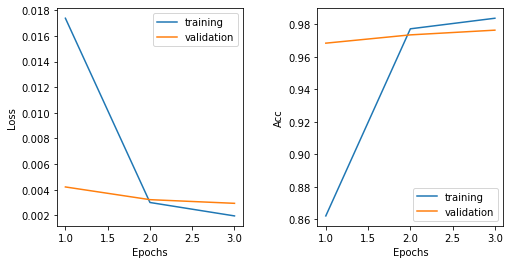

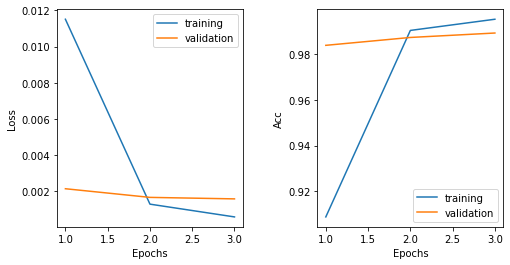

In [23]:
Dlng.learning_curv_ver2(8, 4, 10, 10, ls, vls, acc, vacc)
Dlng.learning_curv_ver2(8, 4, 10, 10, ls2, vls2, acc2, vacc2)

In [ ]:
#NMT(Neural Machine Translation)学習

In [3]:
#英単語辞書作成

tr_en_voc = "./language_process/small_parallel_enja-master/train.en.vocab.4k"

id, eid2w, ew2id = 1, {}, {}
with open(tr_en_voc, 'r', encoding = 'utf-8') as f:
    for w in f:
        w = w.strip()
        eid2w[id] = w
        ew2id[w] = id
        id += 1
#総単語数
ev = id

In [4]:
#日本語辞書作成

tr_ja_voc = "./language_process/small_parallel_enja-master/train.ja.vocab.4k"

id, jid2w, jw2id = 1, {}, {}
with open(tr_ja_voc, 'r', encoding = 'utf-8') as f:
    for w in f:
        w = w.strip()
        jid2w[id] = w
        jw2id[w] = id
        id += 1
#総単語数
jv = id

In [5]:
#英語文訓練データ作成

tr_en = "./language_process/small_parallel_enja-master/train.en"

edata = []
with open(tr_en, 'r', encoding = 'utf-8') as f:
      for sen in f:
        wl = [ew2id['<s>']]
        for w in sen.strip().split():
            if w in ew2id:
                wl.append(ew2id[w])
            else:
                wl.append(ew2id['<unk>'])
        wl.append(ew2id['</s>'])
        edata.append(wl)

In [6]:
#日本語文訓練データ作成

tr_ja = "./language_process/small_parallel_enja-master/train.ja"

jdata = []
with open(tr_ja, 'r', encoding = 'utf-8') as f:
      for sen in f:
        wl = [jw2id['<s>']]
        for w in sen.strip().split():
            if w in jw2id:
                wl.append(jw2id[w])
            else:
                wl.append(jw2id['<unk>'])
        wl.append(jw2id['</s>'])
        jdata.append(wl)

In [7]:
batch_size = 64
dataset = Dlng.MyDataset(jdata, edata)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, collate_fn = Dlng.my_collate_fn)

In [8]:
#日本語文テストデータ作成
te_ja = "./language_process/small_parallel_enja-master/test.ja"

jtest = []
with open(te_ja, 'r', encoding = 'utf-8') as f:
    for sen in f:
        wl = [jw2id['<s>']]
        for w in sen.strip().split():
            if w in jw2id:
                wl.append(jw2id[w])
            else:
                wl.append(jw2id['<unk>'])
        wl.append(jw2id['</s>'])
        jtest.append(wl)

#英語文テストデータ作成
te_en = "./language_process/small_parallel_enja-master/test.en"

etest = []
with open(te_en, 'r', encoding = 'utf-8') as f:
      for sen in f:
        wl = [ew2id['<s>']]
        for w in sen.strip().split():
            if w in ew2id:
                wl.append(ew2id[w])
            else:
                wl.append(ew2id['<unk>'])
        wl.append(ew2id['</s>'])
        etest.append(wl)

batch_size = 64
vset = Dlng.MyDataset(jtest, etest)
vloader = DataLoader(vset, batch_size = batch_size, shuffle = True, collate_fn = Dlng.my_collate_fn)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda', index=0)

In [14]:
demb = 200
net1 = lngmd.MyNMT(jv, ev, demb, 3, 3).to(device)
optimizer1 = optim.Adam(net1.parameters(),lr = 0.01)
criterion1 = nn.CrossEntropyLoss(ignore_index = -1)

net2 = lngmd.MyAttNMT(jv, ev, demb, 3, 3).to(device)
optimizer2 = optim.Adam(net2.parameters(),lr = 0.01)
criterion2 = nn.CrossEntropyLoss(ignore_index = -1)

In [16]:
ls1, vls1 = Dlng.train_nmt_model_ver2(net1, 10, optimizer1, criterion1, device, dataloader, vloader)
ls2, vls2 = Dlng.train_nmt_model_ver2(net2, 10, optimizer2, criterion2, device, dataloader, vloader)

---------------------------------
エポック1 ,train_loss: 0.3103
val_loss: 0.2644
time:0.4375609517097473分
---------------------------------
エポック2 ,train_loss: 0.2478
val_loss: 0.2418
time:0.42651159365971886分
---------------------------------
エポック3 ,train_loss: 0.2264
val_loss: 0.2280
time:0.4232973694801331分
---------------------------------
エポック4 ,train_loss: 0.2105
val_loss: 0.2182
time:0.42788535753885903分
---------------------------------
エポック5 ,train_loss: 0.1978
val_loss: 0.2131
time:0.4238384485244751分
---------------------------------
エポック6 ,train_loss: 0.1882
val_loss: 0.2077
time:0.420927369594574分
---------------------------------
エポック7 ,train_loss: 0.1809
val_loss: 0.2048
time:0.4193037668863932分
---------------------------------
エポック8 ,train_loss: 0.1746
val_loss: 0.2019
time:0.4204232692718506分
---------------------------------
エポック9 ,train_loss: 0.1691
val_loss: 0.2007
time:0.4191383163134257分
---------------------------------
エポック10 ,train_loss: 0.1644
val_loss: 0.1989
tim

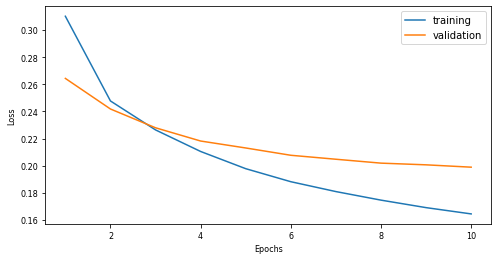

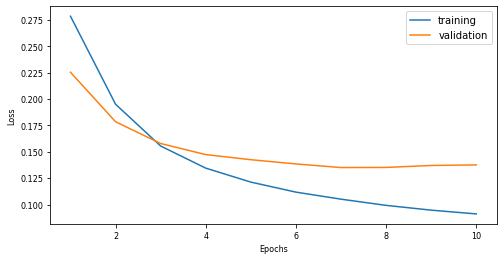

In [18]:
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls1, vls = vls1)
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls2, vls = vsl2)

In [20]:
md_path = './language_process/mymodel/NMT1.pth'
torch.save(net1.state_dict(), md_path)
md_path = './language_process/mymodel/AttNMT1.pth'
torch.save(net2.state_dict(), md_path)

In [11]:
len(jdata), len(edata), len(jtest), len(etest)

(50000, 50000, 500, 500)

In [11]:
demb = 200
net3 = lngmd.MyNMT(jv, ev, demb, 3, 3).to(device)

net4 = lngmd.MyAttNMT(jv, ev, demb, 3, 3).to(device)

md_path = './language_process/mymodel/NMT1.pth'
net3.load_state_dict(torch.load(md_path))
md_path = './language_process/mymodel/AttNMT1.pth'
net4.load_state_dict(torch.load(md_path))

<All keys matched successfully>

In [13]:
trids = Dlng.nmt_trslt_test(net3, jtest, ew2id, device, 500)

trids2 = Dlng.nmt_trslt_test(net4, jtest, ew2id, device, 500)

jtw = Dlng.ids2w_s(jtest, jid2w)

etw = Dlng.ids2w_s(etest, eid2w)

erw = Dlng.ids2w(trids, eid2w)

erw2 = Dlng.ids2w(trids2, eid2w)

In [27]:
len(jtw), len(etw), len(erw), len(erw2)

(500, 500, 500, 500)

In [21]:
Dlng.disp_result(30, jtw, etw, erw)

['彼', 'ら', 'は', 'つい', 'に', 'それ', 'が', '真実', 'だ', 'と', '認め', 'た', '。']


['they', 'finally', 'acknowledged', 'it', 'as', 'true', '.']


['they', 'were', 'in', 'agreement', 'for', 'the', 'fact', '.']


['彼', 'は', '水泳', 'が', '得意', 'で', 'は', 'な', 'かっ', 'た', '。']


['he', 'didn', "'t", 'care', 'for', 'swimming', '.']


['he', 'was', 'very', 'young', 'to', 'go', 'to', 'the', 'station', '.']


['彼', 'は', 'お', '姉', 'さん', 'に', '劣', 'ら', 'ず', '親切', 'だ', '。']


['he', 'is', 'no', 'less', 'kind', 'than', 'his', 'sister', '.']


['he', 'is', 'a', 'good', 'boy', 'of', 'his', 'father', '.']


['１０', '時', '前', 'に', '戻', 'ら', 'な', 'けれ', 'ば', 'な', 'ら', 'な', 'い', '。']


['you', 'must', 'be', 'back', 'before', 'ten', '.']


['i', 'must', 'go', 'to', 'the', 'movies', '.']


['成功', 'を', '祈', 'る', 'わ', '。']


['break', 'a', 'leg', '.']


['i', "'d", 'like', 'to', 'talk', 'with', 'you', '.']


['彼女', 'は', '私', 'たち', 'の', '隣', 'の', '家', 'に', 'す', 'ん', 'で', 'い', 'る', '。']


['she', 'lives', 'next', 'door', 'to'

In [22]:
Dlng.disp_result(30, jtw, etw, erw2)

['彼', 'ら', 'は', 'つい', 'に', 'それ', 'が', '真実', 'だ', 'と', '認め', 'た', '。']


['they', 'finally', 'acknowledged', 'it', 'as', 'true', '.']


['they', 'heard', 'it', 'very', 'hard', 'to', 'understand', 'it', '.']


['彼', 'は', '水泳', 'が', '得意', 'で', 'は', 'な', 'かっ', 'た', '。']


['he', 'didn', "'t", 'care', 'for', 'swimming', '.']


['he', 'was', 'poor', 'at', 'swimming', '.']


['彼', 'は', 'お', '姉', 'さん', 'に', '劣', 'ら', 'ず', '親切', 'だ', '。']


['he', 'is', 'no', 'less', 'kind', 'than', 'his', 'sister', '.']


['he', 'is', 'as', 'kind', 'as', 'to', 'pay', 'with', 'his', 'sister', '.']


['１０', '時', '前', 'に', '戻', 'ら', 'な', 'けれ', 'ば', 'な', 'ら', 'な', 'い', '。']


['you', 'must', 'be', 'back', 'before', 'ten', '.']


['you', 'must', 'be', 'back', 'in', 'ten', 'minutes', '.']


['成功', 'を', '祈', 'る', 'わ', '。']


['break', 'a', 'leg', '.']


['success', 'success', 'success', '.', 'success', '.', 'success', '.', 'success', '.', 'success']


['彼女', 'は', '私', 'たち', 'の', '隣', 'の', '家', 'に', 'す', 'ん', 'で', 'い'

In [24]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate import bleu_score

In [25]:
score = corpus_bleu(etw, erw2, smoothing_function=bleu_score.SmoothingFunction().method1)
score*100

0.01889584463743488

In [26]:
score = corpus_bleu(etw, erw, smoothing_function=bleu_score.SmoothingFunction().method1)
score*100

0.032418888895292784

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mkopm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
#翻訳関数

In [3]:
import nltk
nltk.__version__

'3.7'

In [ ]:
#翻訳モデルver2

In [34]:
demb = 512
net1 = lngmd.MyNMT(jv, ev, demb, 4, 4).to(device)
optimizer1 = optim.Adam(net1.parameters(),lr = 0.001)
criterion1 = nn.CrossEntropyLoss(ignore_index = -1)

net2 = lngmd.MyAttNMT(jv, ev, demb, 4, 4).to(device)
optimizer2 = optim.Adam(net2.parameters(),lr = 0.001)
criterion2 = nn.CrossEntropyLoss(ignore_index = -1)

---------------------------------
エポック1 ,train_loss: 0.3251
val_loss: 0.2684
time:0.5516727288564046分
---------------------------------
エポック2 ,train_loss: 0.2402
val_loss: 0.2227
time:0.5476831316947937分
---------------------------------
エポック3 ,train_loss: 0.2015
val_loss: 0.1986
time:0.5466477513313294分
---------------------------------
エポック4 ,train_loss: 0.1712
val_loss: 0.1793
time:0.5444068471590678分
---------------------------------
エポック5 ,train_loss: 0.1454
val_loss: 0.1673
time:0.553799565633138分
---------------------------------
エポック6 ,train_loss: 0.1236
val_loss: 0.1599
time:0.5498003641764323分
---------------------------------
エポック7 ,train_loss: 0.1049
val_loss: 0.1565
time:0.5549418052037557分
---------------------------------
エポック1 ,train_loss: 0.2951
val_loss: 0.2329
time:0.5583059430122376分
---------------------------------
エポック2 ,train_loss: 0.1921
val_loss: 0.1634
time:0.5611100673675538分
---------------------------------
エポック3 ,train_loss: 0.1329
val_loss: 0.1338
time:0

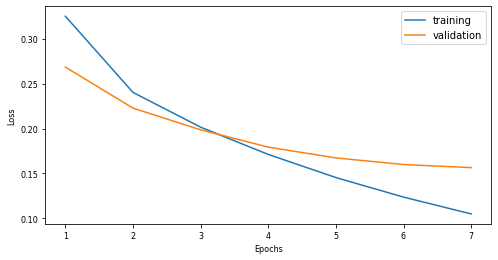

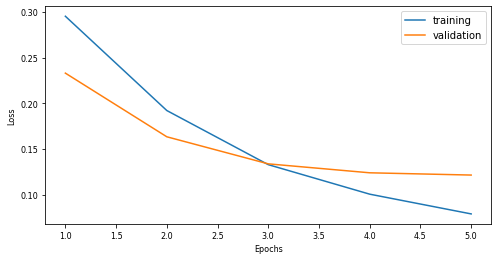

In [35]:
#4layers
ls1, vls1 = Dlng.train_nmt_model_ver2(net1, 7, optimizer1, criterion1, device, dataloader, vloader)
ls2, vls2 = Dlng.train_nmt_model_ver2(net2, 5, optimizer2, criterion2, device, dataloader, vloader)
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls1, vls = vls1)
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls2, vls = vls2)

In [36]:
md_path = './language_process/mymodel/NMT2.pth'
torch.save(net1.state_dict(), md_path)
md_path = './language_process/mymodel/AttNMT2.pth'
torch.save(net2.state_dict(), md_path)

In [37]:
trids = Dlng.nmt_trslt_test(net1, jtest, ew2id, device, 500)

trids2 = Dlng.nmt_trslt_test(net2, jtest, ew2id, device, 500)

jtw = Dlng.ids2w_s(jtest, jid2w)

etw = Dlng.ids2w_s(etest, eid2w)

erw = Dlng.ids2w(trids, eid2w)

erw2 = Dlng.ids2w(trids2, eid2w)

In [38]:
Dlng.disp_result(30, jtw, etw, erw)

['彼', 'ら', 'は', 'つい', 'に', 'それ', 'が', '真実', 'だ', 'と', '認め', 'た', '。']


['they', 'finally', 'acknowledged', 'it', 'as', 'true', '.']


['they', 'looked', 'at', 'the', 'matter', 'with', 'them', '.']


['彼', 'は', '水泳', 'が', '得意', 'で', 'は', 'な', 'かっ', 'た', '。']


['he', 'didn', "'t", 'care', 'for', 'swimming', '.']


['he', 'didn', "'t", 'like', 'his', 'hair', 'very', 'much', '.']


['彼', 'は', 'お', '姉', 'さん', 'に', '劣', 'ら', 'ず', '親切', 'だ', '。']


['he', 'is', 'no', 'less', 'kind', 'than', 'his', 'sister', '.']


['he', 'is', 'not', 'a', 'good', 'musician', 'in', 'his', 'family', '.']


['１０', '時', '前', 'に', '戻', 'ら', 'な', 'けれ', 'ば', 'な', 'ら', 'な', 'い', '。']


['you', 'must', 'be', 'back', 'before', 'ten', '.']


['you', 'must', 'be', 'back', 'within', 'a', 'week', '.']


['成功', 'を', '祈', 'る', 'わ', '。']


['break', 'a', 'leg', '.']


['if', 'you', 'ask', 'your', 'best', ',', 'you', 'will', 'succeed', '.']


['彼女', 'は', '私', 'たち', 'の', '隣', 'の', '家', 'に', 'す', 'ん', 'で', 'い', 'る', '。']


['s

In [39]:
Dlng.disp_result(30, jtw, etw, erw2)

['彼', 'ら', 'は', 'つい', 'に', 'それ', 'が', '真実', 'だ', 'と', '認め', 'た', '。']


['they', 'finally', 'acknowledged', 'it', 'as', 'true', '.']


['they', 'asserted', 'that', 'it', 'was', 'true', '.']


['彼', 'は', '水泳', 'が', '得意', 'で', 'は', 'な', 'かっ', 'た', '。']


['he', 'didn', "'t", 'care', 'for', 'swimming', '.']


['he', 'was', 'not', 'good', 'at', 'the', 'swimming', 'accident', '.']


['彼', 'は', 'お', '姉', 'さん', 'に', '劣', 'ら', 'ず', '親切', 'だ', '。']


['he', 'is', 'no', 'less', 'kind', 'than', 'his', 'sister', '.']


['he', 'is', 'as', 'kind', 'as', 'his', 'sister', '.']


['１０', '時', '前', 'に', '戻', 'ら', 'な', 'けれ', 'ば', 'な', 'ら', 'な', 'い', '。']


['you', 'must', 'be', 'back', 'before', 'ten', '.']


['we', 'have', 'to', 'go', 'back', 'to', 'ten', 'o', "'clock", 'before', '.']


['成功', 'を', '祈', 'る', 'わ', '。']


['break', 'a', 'leg', '.']


['you', 'have', 'to', 'make', 'a', 'success', 'for', 'a', 'job', '.']


['彼女', 'は', '私', 'たち', 'の', '隣', 'の', '家', 'に', 'す', 'ん', 'で', 'い', 'る', '。']


['she'

In [40]:
score = corpus_bleu(etw, erw, smoothing_function=bleu_score.SmoothingFunction().method1)
print(score*100)


score = corpus_bleu(etw, erw2, smoothing_function=bleu_score.SmoothingFunction().method1)
print(score*100)


0.02751952391138046
0.026382990775367272


---------------------------------
エポック1 ,train_loss: 0.3626
val_loss: 0.3501
time:0.7910641630490621分
---------------------------------
エポック2 ,train_loss: 0.3488
val_loss: 0.3450
time:0.7878337979316712分
---------------------------------
エポック3 ,train_loss: 0.3458
val_loss: 0.3456
time:0.7884772936503093分
---------------------------------
エポック4 ,train_loss: 0.3439
val_loss: 0.3443
time:0.7864549279212951分
---------------------------------
エポック5 ,train_loss: 0.3416
val_loss: 0.3409
time:0.7872375249862671分
---------------------------------
エポック1 ,train_loss: 0.3343
val_loss: 0.2834
time:0.8023551940917969分
---------------------------------
エポック2 ,train_loss: 0.2622
val_loss: 0.2502
time:0.8014144897460938分
---------------------------------
エポック3 ,train_loss: 0.2353
val_loss: 0.2369
time:0.7987546682357788分
---------------------------------
エポック4 ,train_loss: 0.2148
val_loss: 0.2220
time:0.8047406911849976分
---------------------------------
エポック5 ,train_loss: 0.1973
val_loss: 0.2126
time:

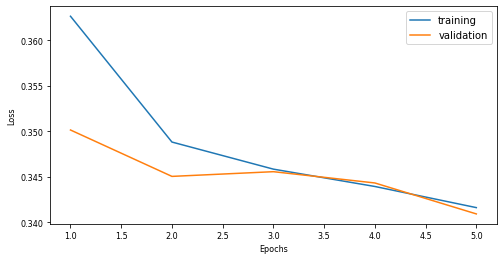

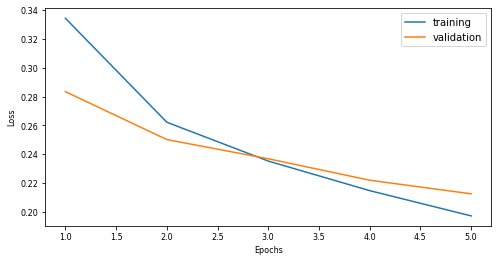

In [33]:
#8layers
ls1, vls1 = Dlng.train_nmt_model_ver2(net1, 5, optimizer1, criterion1, device, dataloader, vloader)
ls2, vls2 = Dlng.train_nmt_model_ver2(net2, 5, optimizer2, criterion2, device, dataloader, vloader)
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls1, vls = vls1)
Dlng.learning_curv_ver2(8, 4, 8, 8, tls = ls2, vls = vls2)

In [ ]:
#BERT

In [3]:
dic = {}
with open("./language_process/BERT-base_mecab-ipadic-bpe-32k/vocab.txt", "r", encoding = "utf-8") as f:
    vocab = f.read()
    for id, word in enumerate(vocab.split('\n')):
        dic[word] = id

In [4]:
from transformers import BertModel
model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese')

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from transformers import BertConfig
config = BertConfig.from_pretrained('cl-tohoku/bert-base-japanese')
config.output_hidden_states = True
model2 = BertModel.from_pretrained('cl-tohoku/bert-base-japanese', config = config)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from transformers import BertJapaneseTokenizer
tknz = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')

In [19]:
tknz.vocab_size

32000

In [4]:
import MeCab

In [6]:
m = MeCab.Tagger("-Owakati")
m.parse("私の好きなスポーツはサッカーです。")
print(m)
tknz.tokenize("私の好きなスポーツはサッカーです。")

<Swig Object of type 'MeCab::Tagger *' at 0x0000024043FC9B80>


['私', 'の', '好き', 'な', 'スポーツ', 'は', 'サッカー', 'です', '。']

In [7]:
tknz.encode("私の好きなスポーツはサッカーです。")

[2, 1325, 5, 3596, 18, 1784, 9, 1301, 2992, 8, 3]

In [8]:
inids = tknz.tokenize("私は[MASK]が好き。")
inids

['私', 'は', '[MASK]', 'が', '好き', '。']

In [9]:
inids = tknz.encode(inids)

In [10]:
inids

[2, 1325, 9, 4, 14, 3596, 8, 3]

In [11]:
mskps = inids.index(tknz.mask_token_id)

In [12]:
mskps

3

In [13]:
from transformers import BertForMaskedLM
model = BertForMaskedLM.from_pretrained('cl-tohoku/bert-base-japanese')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
x = torch.LongTensor(inids).unsqueeze(0)
out = model(x)

In [18]:
len(out), out[0].shape

(1, torch.Size([1, 8, 32000]))

In [22]:
b = torch.topk(out[0][0][mskps], k = 10)
b[0], b[1]

(tensor([8.5865, 8.0724, 7.6974, 7.6480, 7.5863, 7.5578, 7.2595, 7.0979, 7.0369,
         6.9966], grad_fn=<TopkBackward>),
 tensor([1301, 1201,  705, 6968,  450, 6259,  733, 1325, 2606, 3397]))

In [23]:
ans = tknz.convert_ids_to_tokens(b[1])

In [24]:
ans

['サッカー', '野球', '音楽', 'あなた', '映画', '僕', 'ゲーム', '私', '君', 'プロレス']

In [ ]:
#ニュース記事分類

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import pickle

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

xtp = "./language_process/newscorpus/corpusdata/xtrain.pkl"
ytp = "./language_process/newscorpus/corpusdata/ytrain.pkl"

with open(xtp,'br') as fr:
    xtrain = pickle.load(fr)

with open(ytp,'br') as fr:
    ytrain = pickle.load(fr)

In [10]:
net = MyDocCls(bert).to(device)
optimizer = optim.SGD(net.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [5]:
device

device(type='cuda', index=0)

In [12]:
net.train()
for ep in range(30):
    lossK = 0.0
    for i in range(len(xtrain)):
        x = torch.LongTensor(xtrain[i]).unsqueeze(0).to(device)
        y = torch.LongTensor([ ytrain[i] ]).to(device)
        out = net(x)
        loss = criterion(out,y)
        lossK += loss.item()
        if (i % 50 == 0):
            print(ep, i, lossK)
            lossK = 0.0
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#     outfile = "doccls-" + str(ep) + ".model"
#     torch.save(net.state_dict(),outfile)

mdpath = "./language_process/mymodel/ldcc1.pth"
torch.save(net.state_dict(), mdpath)

0 0 2.7597241401672363
0 50 113.6861983537674
0 100 97.16543763875961
0 150 91.85756379365921
0 200 79.58014929294586
0 250 67.70721876621246
0 300 48.52085913717747
0 350 58.66816843301058
0 400 51.58465477079153
0 450 50.18845522031188
0 500 47.48162782937288
0 550 36.240445125848055
0 600 38.653588350862265
0 650 37.903678469359875
0 700 42.48686331883073
1 0 1.2628040313720703
1 50 39.078626649454236
1 100 26.227307682856917
1 150 39.88007743097842
1 200 32.165697356685996
1 250 29.44116431940347
1 300 18.98028916399926
1 350 33.36250124126673
1 400 22.556556710973382
1 450 24.27113613905385
1 500 25.04618902411312
1 550 20.255893538706005
1 600 16.701927057933062
1 650 18.3678791616112
1 700 21.505253614857793
2 0 0.37131690979003906
2 50 25.235414850525558
2 100 12.090440671890974
2 150 24.065688005648553
2 200 14.410186727531254
2 250 12.801263093948364
2 300 10.753393501974642
2 350 17.779048576951027
2 400 9.334715419914573
2 450 15.440605648094788
2 500 11.308239965233952
2 5

21 250 0.10564939679170493
21 300 0.06486404134193435
21 350 0.09951125044608489
21 400 0.11095230728096794
21 450 0.10334625028190203
21 500 0.13763846340953023
21 550 0.10607723270368297
21 600 0.10399350639636395
21 650 0.09530928431195207
21 700 0.13233214196225163
22 0 0.0023498323280364275
22 50 0.11069079994922504
22 100 0.08250599602615694
22 150 0.10043564088846324
22 200 0.08297705640870845
22 250 0.11582097550854087
22 300 0.08331123354582814
22 350 0.09206686912511941
22 400 0.10255213293567067
22 450 0.101891784426698
22 500 0.09291883882542606
22 550 0.09423966136819217
22 600 0.13628618235816248
22 650 0.1326859614928253
22 700 0.10583661320561077
23 0 0.01596994139254093
23 50 0.12369798179133795
23 100 0.08289692875405308
23 150 0.1232171173178358
23 200 0.0920343716206844
23 250 0.06934414131683297
23 300 0.06469369309706963
23 350 0.15035790513502434
23 400 0.06761895523959538
23 450 0.10373204024654115
23 500 0.08871175791500718
23 550 0.08761707138182828
23 600 0.1

In [6]:
xsp = "./language_process/newscorpus/corpusdata/xtest.pkl"
ysp = "./language_process/newscorpus/corpusdata/ytest.pkl"

with open(xsp,'br') as fr:
    xtest = pickle.load(fr)

with open(ysp,'br') as fr:
    ytest = pickle.load(fr)

In [15]:
real_data_num, ok = 0, 0
net.eval()
with torch.no_grad():
    for i in range(len(xtest)):
        x = torch.LongTensor(xtest[i]).unsqueeze(0).to(device)
        ans = net(x)
        ans1 = torch.argmax(ans,dim=1).item()
        if (ans1 == ytest[i]):
            ok += 1
        real_data_num += 1
print(ok, real_data_num, ok/real_data_num)

647 738 0.8766937669376694


In [24]:
dataset = Dlng.MyDataset(xtrain, ytrain)
bs = 4
dataloader = DataLoader(dataset, batch_size = bs, shuffle = True, collate_fn = Dlng.my_collate_fn)

In [25]:
valset = Dlng.MyDataset(xtest, ytest)
bs = 4
valloader = DataLoader(valset, batch_size = bs, shuffle = True, collate_fn = Dlng.my_collate_fn)

In [26]:
from transformers import BertModel
bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
net2 = lngmd.MyDocCls_attmsk(bert).to(device)
optimizer = optim.SGD(net2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

---------------------------------
エポック1 ,train_loss: 0.4311819578897016 ,train_acc: 0.45799457994579945
val_loss: 0.2748, val_acc: 0.7019
time:0.7743874629338582分
---------------------------------
エポック2 ,train_loss: 0.2297604983132383 ,train_acc: 0.7425474254742548
val_loss: 0.1983, val_acc: 0.7385
time:0.7719515124956767分
---------------------------------
エポック3 ,train_loss: 0.15488258224273438 ,train_acc: 0.8197831978319783
val_loss: 0.1546, val_acc: 0.8130
time:0.7714068412780761分
---------------------------------
エポック4 ,train_loss: 0.11455900580458202 ,train_acc: 0.8807588075880759
val_loss: 0.1574, val_acc: 0.8076
time:0.7716243743896485分
---------------------------------
エポック5 ,train_loss: 0.09187518762863749 ,train_acc: 0.9010840108401084
val_loss: 0.1321, val_acc: 0.8198
time:0.7739251891771952分
---------------------------------
エポック6 ,train_loss: 0.06797738406595176 ,train_acc: 0.940379403794038
val_loss: 0.1185, val_acc: 0.8347
time:0.7742801745732625分
------------------------

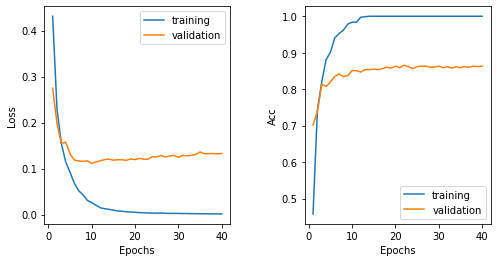

In [28]:
tls, vls, tas, vas = Dlng.train_bert_doccls_model(net2, 40, optimizer, criterion, device, dataloader, valloader)
Dlng.learning_curv_ver2(8, 4, 10, 10, tls, vls, tas, vas)

md_path = './language_process/mymodel/doccls1.pth'
torch.save(net2.state_dict(), md_path)

In [10]:
tmp = dataloader.__iter__()

x1, y1 = tmp.next()

In [11]:
len(x1), len(y1)

(4, 4)

In [24]:
y1

[8,
 2,
 7,
 8,
 6,
 2,
 8,
 0,
 0,
 2,
 8,
 7,
 1,
 7,
 2,
 3,
 6,
 4,
 3,
 8,
 3,
 6,
 7,
 2,
 7,
 8,
 2,
 0,
 6,
 4,
 6,
 7]

In [27]:
len(x1[0])

203

In [12]:
xsl, xmsk = batch_pad_bert_msk(x1, device)

In [13]:
xsl.shape, xmsk.shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [14]:
len(y1)

4

In [39]:
y1

[8,
 2,
 7,
 8,
 6,
 2,
 8,
 0,
 0,
 2,
 8,
 7,
 1,
 7,
 2,
 3,
 6,
 4,
 3,
 8,
 3,
 6,
 7,
 2,
 7,
 8,
 2,
 0,
 6,
 4,
 6,
 7]

In [20]:
net2.train()
output = net2(xsl, xmsk)

In [21]:
output.shape

torch.Size([4, 9])

In [22]:
y1

[5, 7, 0, 8]

In [26]:
y1 = torch.LongTensor(y1).to(device)
loss = criterion(output, y1)
loss.item()

2.3048088550567627

In [27]:
ans = torch.argmax(output, dim = 1)
ans

tensor([7, 6, 8, 6], device='cuda:0')

In [28]:
correct = torch.sum(ans == y1).item()
correct

0